In [54]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer



In [65]:
datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
}

data_dict = {}
for name, url in datasets.items():
    data = pd.read_csv(url, header=None)

    if name == 'us_crime':
        data = data.drop(columns=[3])
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1]  # Target is the last column
    elif name == 'letter_img':
        # data = data.drop(columns=[0])
        X = data.iloc[1:, 1:]  # Features start from the second column
        y = data.iloc[1:, 0]   # Target is the first column
        print(y)
    elif name == 'mammography':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1]  # Target is the last column
    data_dict[name] = (X, y)
data_dict['letter_img'][1]

1        T
2        I
3        D
4        N
5        G
        ..
19996    D
19997    C
19998    T
19999    S
20000    A
Name: 0, Length: 20000, dtype: object


,0
1,T
2,I
3,D
4,N
5,G
...,...
19996,D
19997,C
19998,T
19999,S


In [56]:
datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
}

data_dict = {}
for name, url in datasets.items():
    data = pd.read_csv(url, header=None)

    if name == 'us_crime':
        data = data.drop(columns=[3])
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(float).apply(lambda x: 1 if x > 0.65 else 0).astype(int)  # Target is the last column
    elif name == 'letter_img':
        X = data.iloc[1:, 1:]  # Features start from the second column
        y = data.iloc[1:, 0].apply(lambda x: 1 if x == 'Z' else 0).astype(int)   # Target is the first column
    elif name == 'mammography':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(int)  # Target is the last column
    data_dict[name] = (X, y)


In [58]:
def calculate_f1_scores(X, y):
    f1_scores = []
    for i in range(X.shape[1]):
        X_feature = X.iloc[:, i].values.reshape(-1, 1)

        # Convert '?' to NaN and then impute missing values
        X_feature = np.where(X_feature == '?', np.nan, X_feature)
        imputer = SimpleImputer(strategy='most_frequent') # Or another suitable strategy
        X_feature = imputer.fit_transform(X_feature)

        X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.25, random_state=42)

        # if is_binary:
        #     y_train = y_train.astype(str)
        #     y_test = y_test.astype(str)

        clf = DecisionTreeClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        average = 'binary'
        f1 = f1_score(y_test, y_pred, average= average)
        f1_scores.append(f1)

    return f1_scores


In [59]:
def evaluate_svm_with_selected_features(X, y, feature_ranking, fractions):
    results = {'fraction': [], 'f1_score': [], 'precision': [], 'recall': []}

    for fraction in fractions:
        num_features = max(1, int(fraction * X.shape[1])) # ensure that at least one feature is selected.
        selected_features = feature_ranking[:num_features]
        X_selected = X.iloc[:, selected_features]

        # Convert '?' to NaN and then impute missing values
        X_selected = np.where(X_selected == '?', np.nan, X_selected)
        imputer = SimpleImputer(strategy='mean') #most_frequent
        X_selected = imputer.fit_transform(X_selected)

        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        print("Unique values in y_train:", np.unique(y_train))

        svm = SVC(kernel='rbf', class_weight= 'balanced')
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        average = 'binary'
        f1 = f1_score(y_test, y_pred, average= average)
        precision = precision_score(y_test, y_pred, average= average)
        recall = recall_score(y_test, y_pred, average= average)

        results['fraction'].append(fraction)
        results['f1_score'].append(f1)
        results['precision'].append(precision)
        results['recall'].append(recall)

    return results


In [ ]:
X

,0,1,2,3,4
1,5,67,3,5,3
2,4,43,1,1,NaN
3,5,58,4,5,3
4,4,28,1,1,3
5,5,74,1,5,NaN
...,...,...,...,...,...
957,4,47,2,1,3
958,4,56,4,5,3
959,4,64,4,5,3
960,5,66,4,5,3


In [ ]:
feature_ranking
# f1_scores

array([6, 5, 9, 8, 7, 2, 1, 0, 4, 3])

Evaluating dataset: us_crime


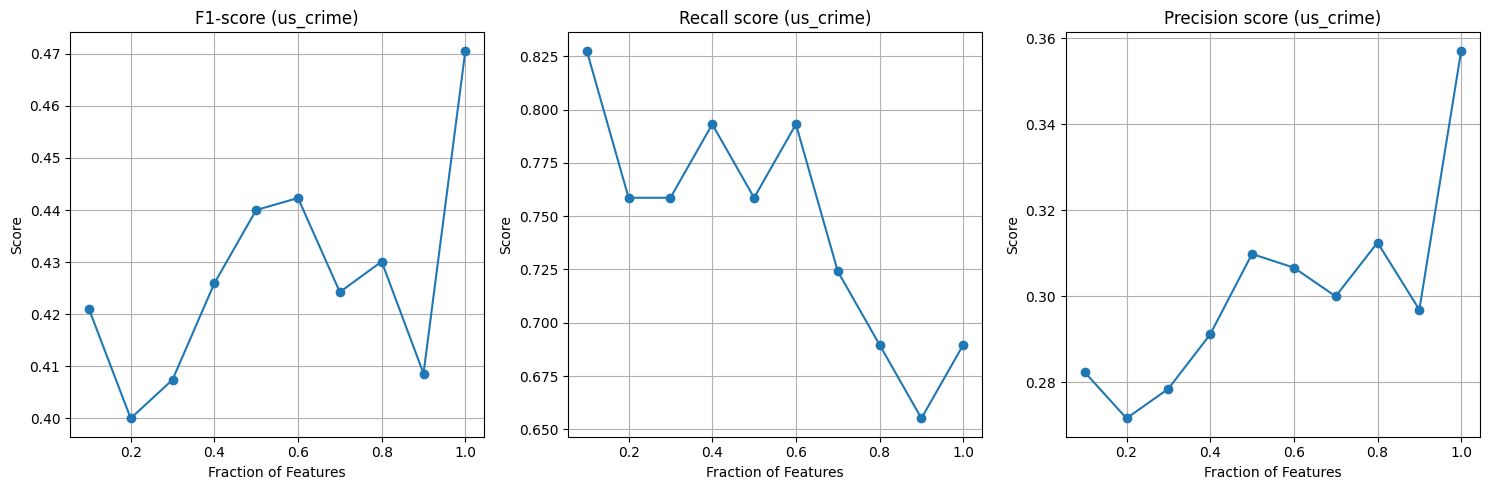

Evaluating dataset: letter_img


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

ValueError: The number of classes has to be greater than one; got 1 class

In [60]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for name, (X, y) in data_dict.items():
    print(f"Evaluating dataset: {name}")

    # Calculate F1-scores for all features
    # is_binary= False
    # if name == 'us_crime':
    #     is_binary = False
    # elif name == 'letter_img':
    #     is_binary = False
    # elif name == 'mammography':
    #     is_binary = True
    f1_scores = calculate_f1_scores(X, y)

    # Rank features based on F1-scores
    feature_ranking = np.argsort(f1_scores)[::-1]

    # Evaluate SVM classifier with selected features
    results = evaluate_svm_with_selected_features(X, y, feature_ranking, fractions)

    # Extract the scores for plotting
    f1_scores = results['f1_score']
    recall_scores = results['recall']
    precision_scores = results['precision']

    # Plot the results
    plt.figure(figsize=(15, 5))

    # Plot F1-score
    plt.subplot(1, 3, 1)
    plt.plot(fractions, f1_scores, label='F1-score', marker='o')
    plt.title(f'F1-score ({name})')
    plt.xlabel('Fraction of Features')
    plt.ylabel('Score')
    plt.grid(True)

    # Plot Recall score
    plt.subplot(1, 3, 2)
    plt.plot(fractions, recall_scores, label='Recall score', marker='o')
    plt.title(f'Recall score ({name})')
    plt.xlabel('Fraction of Features')
    plt.ylabel('Score')
    plt.grid(True)

    # Plot Precision score
    plt.subplot(1, 3, 3)
    plt.plot(fractions, precision_scores, label='Precision score', marker='o')
    plt.title(f'Precision score ({name})')
    plt.xlabel('Fraction of Features')
    plt.ylabel('Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
